In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import warnings
from scipy import stats
import datetime as dt
import scipy.interpolate as interpolate
from mySSA import mySSA

In [2]:
volc = np.genfromtxt('nature14565-s6_sigl2015.csv', delimiter=",", dtype=float)
data_dandak = np.genfromtxt('dandak2010_v1.txt', delimiter=",", dtype=float) # ismr reconstruction

In [3]:
yy_dandak = np.flip(data_dandak[:,0])
ismr_dandak = np.flip(data_dandak[:,1])

yy_dandak_ann = np.arange( np.trunc(np.min(yy_dandak))+1 ,np.trunc(np.max(yy_dandak)))
ismr_dandak_ann = np.zeros((yy_dandak_ann.shape[0]))

f = interpolate.interp1d(yy_dandak, ismr_dandak, kind='linear')
for i in range(yy_dandak_ann.shape[0]):
    ismr_dandak_ann[i] = f(yy_dandak_ann[i])


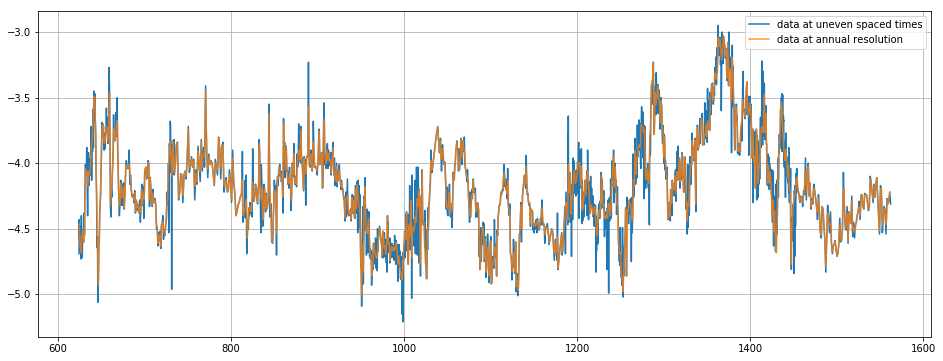

In [4]:
plt.figure(figsize=(16,6))
plt.plot(yy_dandak, ismr_dandak, label='data at uneven spaced times')
plt.plot(yy_dandak_ann, ismr_dandak_ann, label='data at annual resolution', alpha=0.8)
plt.legend()
plt.grid()

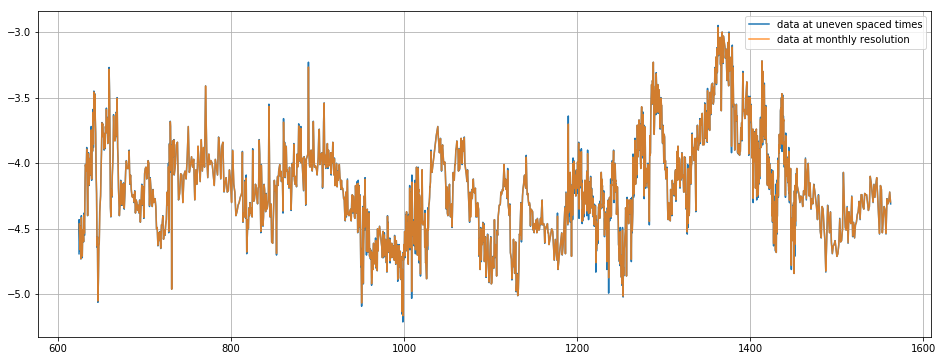

In [5]:
yy_dandak = np.flip(data_dandak[:,0])
ismr_dandak = np.flip(data_dandak[:,1])

yy_dandak_mon = np.arange( np.trunc(np.min(yy_dandak))+1 ,np.trunc(np.max(yy_dandak)),1/12 )
ismr_dandak_mon = np.zeros((yy_dandak_mon.shape[0]))

f = interpolate.interp1d(yy_dandak, ismr_dandak, kind='linear')
for i in range(yy_dandak_mon.shape[0]):
    ismr_dandak_mon[i] = f(yy_dandak_mon[i])

plt.figure(figsize=(16,6))
plt.plot(yy_dandak, ismr_dandak, label='data at uneven spaced times')
plt.plot(yy_dandak_mon, ismr_dandak_mon, label='data at monthly resolution', alpha=0.8)
plt.legend()
plt.grid()

In [6]:
# Singular Spectral Analysis as in Sinha et al 2015
def X_to_TS(X_i):
    """Averages the anti-diagonals of the given elementary matrix, X_i, and returns a time series."""
    # Reverse the column ordering of X_i
    X_rev = X_i[::-1]
    # Full credit to Mark Tolonen at https://stackoverflow.com/a/6313414 for this one:
    return np.array([X_rev.diagonal(i).mean() for i in range(-X_i.shape[0]+1, X_i.shape[1])])

def ssa(F):
    N = F.shape[0]
    L = 30# The window length.
    K = N - L + 1 # The number of columns in the trajectory matrix.
    # Create the trajectory matrix by pulling the relevant subseries of F, and stacking them as columns.
    X = np.column_stack([F[i:i+L] for i in range(0,K)])
    # Note: the i+L above gives us up to i+L-1, as numpy array upper bounds are exclusive. 
    d = np.linalg.matrix_rank(X) # The intrinsic dimensionality of the trajectory space.
    U, Sigma, V = np.linalg.svd(X)
    V = V.T # Note: the SVD routine returns V^T, not V, so I'll tranpose it back here. This may seem pointless, 
    X_elem = np.array( [Sigma[i] * np.outer(U[:,i], V[:,i]) for i in range(0,d)] )
    n = min(12,d) # In case of noiseless time series with d < 12.
    # Convert elementary matrices straight to a time series - no need to construct any Hankel matrices.
    F_i = np.zeros((n,N))
    for i in range(n):
        F_i[i,:] = X_to_TS(X_elem[i])
    return F_i


In [7]:
ismr_dandak_mon_anom = ismr_dandak_mon
# Monthly anomalies
for i in range(yy_dandak_ann.shape[0]):
    ismr_dandak_mon_anom[i::12] = ismr_dandak_mon[i::12] - np.mean(ismr_dandak_mon[i::12])
    #print(np.arange(i,yy_dandak_ann.shape[0],12))
    #ismr_dandak_ann[i] = np.sum(ismr_dandak_mon[i*12:(i+1)*12])

In [8]:
ismr_dandak_mon_anom_ssa = ssa(ismr_dandak_mon_anom)

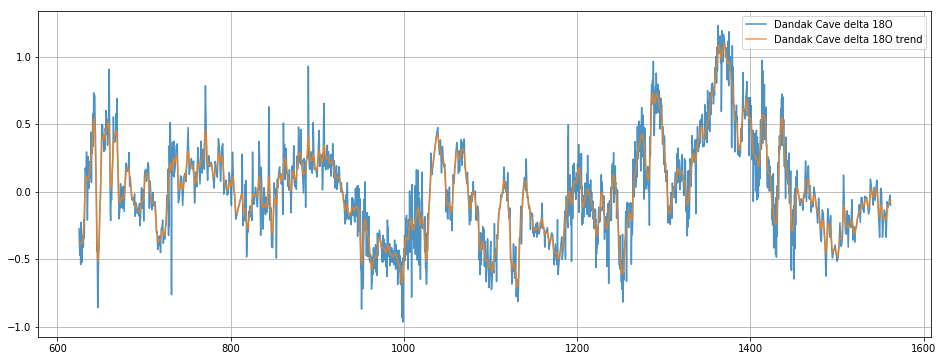

In [9]:
# Trend from Singular Spectral Analysis
plt.figure(figsize=(16,6))
plt.plot(yy_dandak_mon, ismr_dandak_mon_anom, label='Dandak Cave delta 18O', alpha=0.8)
plt.plot(yy_dandak_mon, ismr_dandak_mon_anom_ssa[0], label='Dandak Cave delta 18O trend', alpha=0.8)
plt.legend()
plt.grid()

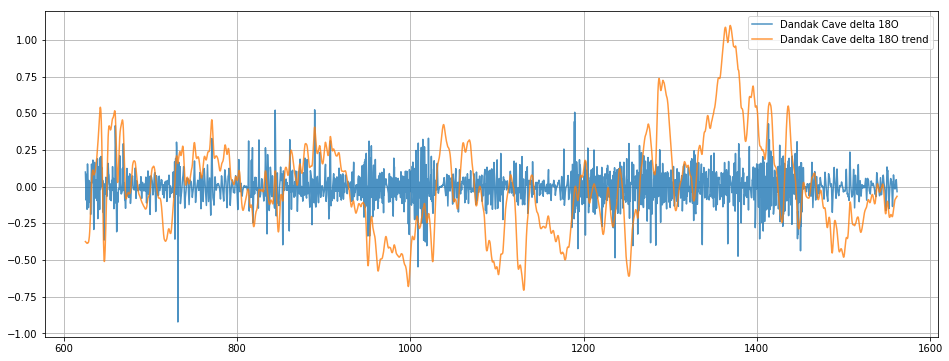

In [10]:
# DeTrend from Singular Spectral Analysis
plt.figure(figsize=(16,6))
plt.plot(yy_dandak_mon, ismr_dandak_mon_anom-ismr_dandak_mon_anom_ssa[0], label='Dandak Cave delta 18O', alpha=0.8)
plt.plot(yy_dandak_mon, ismr_dandak_mon_anom_ssa[0], label='Dandak Cave delta 18O trend', alpha=0.8)
plt.legend()
plt.grid()

In [11]:
# Yearly anomalies
ismr_dandak_ann_anom = np.zeros((ismr_dandak_ann.shape[0]))
for i in range(ismr_dandak_ann_anom.shape[0]):
    ismr_dandak_ann_anom[i] = np.mean(ismr_dandak_ann[i:i+12])

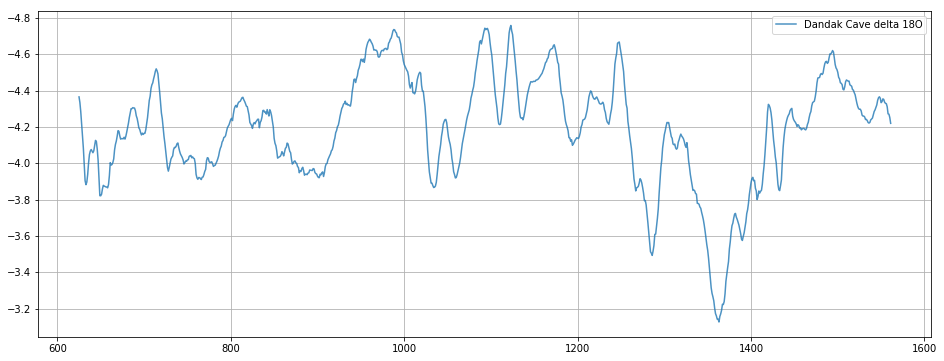

In [12]:
plt.figure(figsize=(16,6))
plt.plot(yy_dandak_ann, ismr_dandak_ann_anom, label='Dandak Cave delta 18O', alpha=0.8)
plt.legend()
plt.gca().invert_yaxis()
plt.grid()

In [13]:
# Running SSA on these yearly anomalies
ismr_dandak_ann_anom_ssa = ssa(ismr_dandak_ann_anom)

ismr_dandak_ann_anom_1 = ismr_dandak_ann_anom - ismr_dandak_ann_anom_ssa[0]
ismr_dandak_ann_anom_norm = (ismr_dandak_ann_anom_1 - np.mean(ismr_dandak_ann_anom_1))/(np.std(ismr_dandak_ann_anom_1))

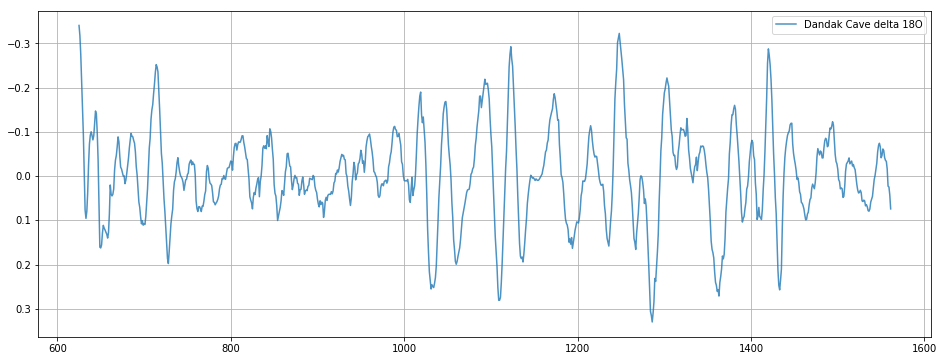

In [14]:
plt.figure(figsize=(16,6))
plt.plot(yy_dandak_ann, ismr_dandak_ann_anom-ismr_dandak_ann_anom_ssa[0], label='Dandak Cave delta 18O', alpha=0.8)
plt.legend()
plt.grid()
plt.gca().invert_yaxis()

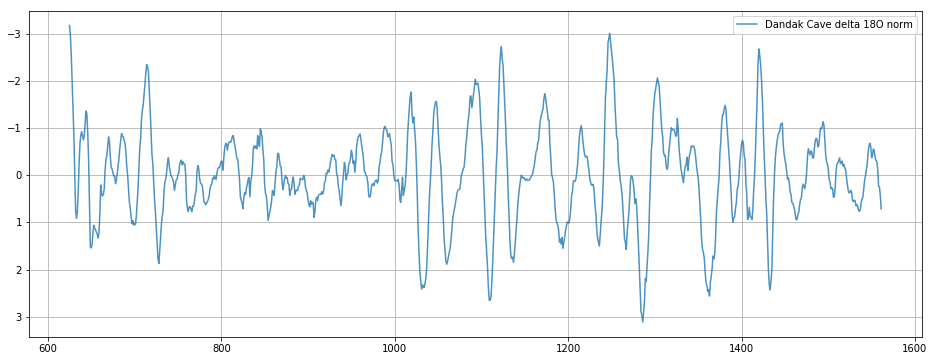

In [15]:
plt.figure(figsize=(16,6))
plt.plot(yy_dandak_ann, ismr_dandak_ann_anom_norm, label='Dandak Cave delta 18O norm', alpha=0.8)
plt.legend()
plt.grid()
plt.gca().invert_yaxis()

In [16]:
event_drought_dandak = np.zeros((yy_dandak_ann.shape[0]))
event_yy_volc_all = np.zeros((yy_dandak_ann.shape[0]))
event_yy_volc_strong = np.zeros((yy_dandak_ann.shape[0]))
event_yy_volc_all_trop = np.zeros((yy_dandak_ann.shape[0]))
event_yy_volc_all_nh = np.zeros((yy_dandak_ann.shape[0]))
event_yy_volc_all_sh = np.zeros((yy_dandak_ann.shape[0]))
event_yy_volc_strong_trop = np.zeros((yy_dandak_ann.shape[0]))
event_yy_volc_strong_nh = np.zeros((yy_dandak_ann.shape[0]))
event_yy_volc_strong_sh = np.zeros((yy_dandak_ann.shape[0]))

In [17]:
event_drought_dandak[ismr_dandak_ann_anom_norm>1.0] = 1.0

for i in range(yy_dandak_ann.shape[0]):
    #print(event_yy_kobb[i])
    idx = np.asarray(np.where(volc[:,0] == yy_dandak_ann[i]))
    #print(idx.size)
    if idx.size==0:
        continue
    event_yy_volc_all[i] = 5.0
    if np.abs(volc[idx[0,0],2])>=1.0:
        event_yy_volc_strong[i] = 1.0
    
    if volc[idx[0,0],1] == 1.0:
        event_yy_volc_all_trop[i] = 1.0
    if volc[idx[0,0],1] == 2.0:
        event_yy_volc_all_nh[i] = 1.0
    if volc[idx[0,0],1] == 3.0:
        event_yy_volc_all_sh[i] = 1.0
        
    if (volc[idx[0,0],1] == 1.0) & (np.abs(volc[idx[0,0],2])>=3.7):
        event_yy_volc_strong_trop[i] = 1.0
    if (volc[idx[0,0],1] == 2.0) & (np.abs(volc[idx[0,0],2])>=3.7):
        event_yy_volc_strong_nh[i] = 1.0
    if (volc[idx[0,0],1] == 3.0) & (np.abs(volc[idx[0,0],2])>=3.7):
        event_yy_volc_strong_sh[i] = 1.0

In [18]:
ismr_dandak_2010_anom_yy = np.zeros((ismr_dandak_ann_anom_norm.shape[0],3))
ismr_dandak_2010_anom_yy[:,0] = yy_dandak_ann[:]
ismr_dandak_2010_anom_yy[:,1] = event_yy_volc_strong[:]
ismr_dandak_2010_anom_yy[:,2] = -ismr_dandak_ann_anom_norm[:]
np.savetxt('ismr_dandak_2010_anom_yy.txt', ismr_dandak_2010_anom_yy, delimiter=",")